In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score,KFold,cross_validate
from sklearn.metrics  import classification_report ,make_scorer,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Non HyperParamter 에서 모델들의 성능 검증

In [12]:

class Model():
    def __init__(self,data,zscore=False,smote = False,adasyn=False,drop=None,std=False):
        
        self.df = data
        if drop is not None:
            data = data.drop(drop,axis=1)
        self.word_num()
        self.data = data
        if zscore==True:
            data = self.zscore_df(data)
        self.X = data.drop(['id', 'quality'],axis=1)
        self.y = data['quality']
        if smote==True:
            self.X, self.y = SMOTE(random_state=0).fit_resample(self.X,self.y)
        elif adasyn==True:
            self.X, self.y = ADASYN(random_state=0).fit_resample(self.X,self.y)
        elif std == True:
            self.X = StandardScaler().fit_transform(self.X)
        self.X_train,self.X_test,self.y_train,self.y_test = train_test_split(self.X,self.y,
                                                                            test_size=0.4,
                                                                            random_state=42)
        
    def data_return(self):
        return self.X_train,self.X_test,self.y_train,self.y_test
    def Logistic(self,linear = 'liblinear'):
        model = LogisticRegression(solver = linear)
        model.fit(self.X_train,self.y_train)
        prediction = model.predict(self.X_test)
        score = self.evaluate_model(self.X_test,self.y_test,model)
        print(f"모델의 정확도는 {np.mean(score)}% 입니다")
        self.__init__(self.data)
        
        return model
    def grid_model(self,model_type,param=None):
        model = GridSearchCV(model_type,param,scoring = 'accuracy',cv=3)
        model = model_type
        model.fit(self.X_train,self.y_train)
        prediction = model.predict(self.X_test)
        score = self.evaluate_model(self.X_test,self.y_test,model)
        self.__init__(self.data)
        print(f"모델의 정확도는 {np.mean(score)}% 입니다")
        return model
    def count_plot(self): 
        counter = Counter(self.y)
        for k,v in counter.items():
            print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
        pyplot.bar(counter.keys(), counter.values())
        pyplot.show()
    def word_num(self):
        word_to_num = {'white' : 0, 'red' : 1}
        self.df['type'] = self.df['type'].replace(word_to_num)
    def evaluate_model(self,X, y, model):
        cv = KFold(n_splits=10, shuffle=True)
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
        return scores
    def zscore_df(self,df):
        
        data = df.iloc[:,1:-1].apply(stats.zscore)
        
        data['quality'] = df['quality']
        data['id'] = df['id']
        #data['type'] = df['type']
        
        for i in data.iloc[:,:-2].columns:
            data = data.loc[(data[i] > -2) & (data[i] < 2)]
       
        return data
        

In [13]:
def evaluate_model(X, y, model):
        cv = KFold(n_splits=10, shuffle=True)
        scores = cross_val_score(model, X, y, cv=cv, scoring=make_scorer(accuracy_score),n_jobs=-1)
        return np.mean(scores)


In [ ]:
def evaluate_model(X, y, model):
        cv = KFold(n_splits=10, shuffle=True)
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
        return np.mean(scores)


In [5]:
train_path = '../train/train.csv'
test_path = '../test/test.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


In [180]:
# total sulfur dioxide 와 free sulfur dioxide의 상관계수가 높기때문에 삭제
# -> 별다른 결과가 나타나지 않음
# 와인의 품질을 7이상은 high, 미만은 low로 지정하여 feature 생성

In [422]:
train_df.describe()

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
count,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000
mean,1616.000000,7.205772,0.336072,0.319496,5.454813,0.055890,30.583720,116.256577,0.994667,3.214166,0.531455,10.497108,0.240792,5.829155
std,932.853686,1.295494,0.160285,0.145854,4.816098,0.035722,17.387143,55.759070,0.003054,0.161873,0.149686,1.193813,0.427631,0.850003
min,1.000000,3.800000,0.080000,0.000000,0.600000,0.012000,1.000000,6.000000,0.987110,2.720000,0.220000,8.400000,0.000000,4.000000
25%,808.500000,6.400000,0.227500,0.250000,1.800000,0.038000,17.000000,78.000000,0.992205,3.100000,0.430000,9.500000,0.000000,5.000000
50%,1616.000000,7.000000,0.290000,0.310000,3.100000,0.047000,29.000000,119.000000,0.994840,3.200000,0.510000,10.300000,0.000000,6.000000
75%,2423.500000,7.700000,0.400000,0.390000,8.100000,0.064000,42.000000,156.000000,0.996900,3.320000,0.600000,11.300000,0.000000,6.000000
max,3231.000000,15.900000,1.040000,1.660000,65.800000,0.611000,131.000000,344.000000,1.038980,4.010000,1.980000,14.900000,1.000000,8.000000


In [14]:
train_model = Model(train_df,zscore=True,smote=True,drop='total sulfur dioxide').Logistic()



모델의 정확도는 0.4247524752475248% 입니다


In [16]:
from sklearn.tree import DecisionTreeClassifier
regressor = DecisionTreeClassifier()

param_grid ={'max_depth':(1,2,3,4,5,6,7,8,9,10)}

model = Model(train_df,zscore=True,smote=True,drop='total sulfur dioxide')
train_model = model.grid_model(regressor,param_grid)

모델의 정확도는 0.6168316831683167% 입니다


In [15]:
from xgboost import XGBClassifier
xgbr = XGBClassifier()
param_grid = param_grid={'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['binary:logistic'],
                 'random_state':[2]}
mmodel = Model(train_df,zscore=True,drop='total sulfur dioxide')
train_model = model.grid_model(xgbr,param_grid)

NameError: name 'model' is not defined

In [33]:

test = pd.read_csv('../test/test.csv')
word_to_num = {"white":0, "red":1}

test['type'] = test['type'].replace(word_to_num)
test =  test.apply(stats.zscore)
prediction = train_model.predict(test.drop('id', axis=1))


submission = pd.read_csv('../sample_submission.csv')
submission['quality'] = prediction
submission.to_csv("../submission/xgb.csv", index=False)

In [237]:
# df['goodquality'] = [1 if x >= 7 else 0 for x in df['quality']]
# df['goodquality'].value_counts()                     

0    1756
1     465
Name: goodquality, dtype: int64

In [363]:
train_df

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,1,8.0,0.18,0.37,1.30,0.040,15.0,96.0,0.99120,3.06,0.61,12.1,0,6
1,2,7.5,0.38,0.29,4.90,0.021,38.0,113.0,0.99026,3.08,0.48,13.0,0,7
2,3,6.1,0.27,0.33,2.20,0.021,26.0,117.0,0.98860,3.12,0.30,12.5,0,6
3,4,6.4,0.32,0.50,10.70,0.047,57.0,206.0,0.99680,3.08,0.60,9.4,0,5
4,5,8.4,0.37,0.43,2.30,0.063,12.0,19.0,0.99550,3.17,0.81,11.2,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226,3227,6.4,0.16,0.31,5.30,0.043,42.0,157.0,0.99455,3.35,0.47,10.5,0,5
3227,3228,6.4,0.18,0.28,17.05,0.047,53.0,139.0,0.99724,3.25,0.35,10.5,0,6
3228,3229,6.0,0.28,0.25,1.80,0.042,8.0,108.0,0.99290,3.08,0.55,9.0,0,5
3229,3230,7.7,0.28,0.29,6.90,0.041,29.0,163.0,0.99520,3.44,0.60,10.5,0,6


In [398]:
# X = df.drop(['quality','goodquality','id'], axis = 1) 
# y = df['goodquality']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

X_train, X_test, y_train, y_test = Model(train_df,zscore=True).data_return()
print('zscore')
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train,y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,zscore=True,smote=True).data_return()
print('zscore + Smote')
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train,y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,zscore=True,drop='type').data_return()
print('zscore + drop type')
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train,y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,zscore=True,drop='type',smote=True).data_return()
print('zscore + drop type + smote')
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train,y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,std=True,smote=True,drop='type').data_return()
print('std + drop type + smote')
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train,y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,std=True).data_return()
print('std')
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train,y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))
print(evaluate_model(X_test,y_test,model))

zscore
              precision    recall  f1-score   support

           4       1.00      0.05      0.10        19
           5       0.62      0.61      0.61       290
           6       0.53      0.75      0.62       402
           7       0.54      0.14      0.23       153
           8       0.00      0.00      0.00        25

    accuracy                           0.56       889
   macro avg       0.54      0.31      0.31       889
weighted avg       0.56      0.56      0.52       889

0.5546475995914197
zscore + drop type
              precision    recall  f1-score   support

           4       1.00      0.05      0.10        19
           5       0.63      0.61      0.62       290
           6       0.54      0.75      0.63       402
           7       0.51      0.14      0.22       153
           8       0.00      0.00      0.00        25

    accuracy                           0.56       889
   macro avg       0.54      0.31      0.31       889
weighted avg       0.56      0.5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

0.5523748723186925
zscore + drop type + smote
              precision    recall  f1-score   support

           4       0.53      0.68      0.60       386
           5       0.47      0.50      0.48       404
           6       0.28      0.15      0.20       393
           7       0.47      0.33      0.39       403
           8       0.46      0.65      0.54       400

    accuracy                           0.46      1986
   macro avg       0.44      0.46      0.44      1986
weighted avg       0.44      0.46      0.44      1986

0.4562306481904471
std + drop type + smote
              precision    recall  f1-score   support

           4       0.52      0.72      0.60       544
           5       0.42      0.43      0.42       589
           6       0.31      0.15      0.21       583
           7       0.40      0.32      0.36       561
           8       0.44      0.56      0.49       559

    accuracy                           0.43      2836
   macro avg       0.42      0.44      0.4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [399]:



X_train, X_test, y_train, y_test = Model(train_df,zscore=True).data_return()
print('zscore')
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,zscore=True,drop='type').data_return()
print('zscore + drop type')
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,zscore=True,drop='type',smote=True).data_return()
print('zscore + drop type + smote')
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,std=True,smote=True,drop='type').data_return()
print('std + drop type + smote')
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,std=True).data_return()
print('std')
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

zscore
              precision    recall  f1-score   support

           4       0.09      0.16      0.12        19
           5       0.56      0.55      0.55       290
           6       0.57      0.56      0.56       402
           7       0.41      0.39      0.40       153
           8       0.28      0.28      0.28        25

    accuracy                           0.51       889
   macro avg       0.38      0.39      0.38       889
weighted avg       0.52      0.51      0.51       889

0.4780771195097038
zscore + drop type
              precision    recall  f1-score   support

           4       0.08      0.11      0.09        19
           5       0.58      0.58      0.58       290
           6       0.57      0.57      0.57       402
           7       0.42      0.39      0.40       153
           8       0.27      0.32      0.29        25

    accuracy                           0.52       889
   macro avg       0.38      0.39      0.39       889
weighted avg       0.53      0.5

<AxesSubplot:>

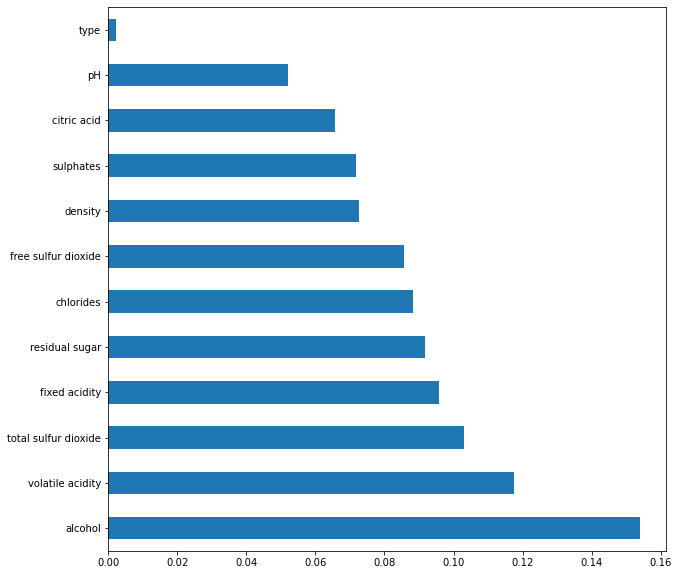

In [400]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

In [424]:
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = Model(train_df,zscore=True).data_return()
print('zscore')
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,zscore=True,smote=True).data_return()
print('zscore + Smote')
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,zscore=True,adasyn=True).data_return()
print('zscore + adasyn')
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,zscore=True,drop='type').data_return()
print('zscore + drop type')
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,zscore=True,drop='type',smote=True).data_return()
print('zscore + drop type + smote')
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,std=True,smote=True,drop='type').data_return()
print('std + drop type + smote')
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,std=True).data_return()
print('std')
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))


zscore
              precision    recall  f1-score   support

           4       1.00      0.11      0.19        19
           5       0.66      0.62      0.64       290
           6       0.57      0.73      0.64       402
           7       0.56      0.33      0.41       153
           8       0.78      0.28      0.41        25

    accuracy                           0.60       889
   macro avg       0.71      0.41      0.46       889
weighted avg       0.61      0.60      0.59       889

0.6029622063329929
zscore + Smote
              precision    recall  f1-score   support

           4       0.90      0.99      0.94       386
           5       0.74      0.77      0.75       404
           6       0.64      0.50      0.56       393
           7       0.80      0.85      0.82       403
           8       0.93      0.97      0.95       400

    accuracy                           0.81      1986
   macro avg       0.81      0.81      0.81      1986
weighted avg       0.80      0.81   

<AxesSubplot:>

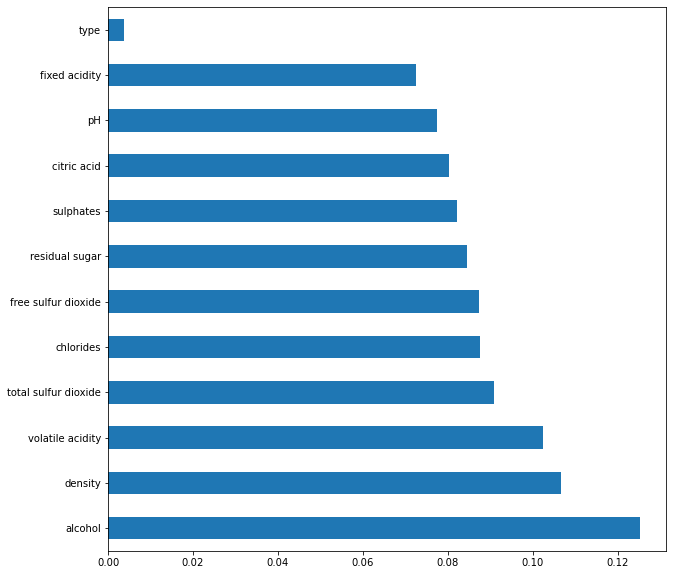

In [402]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

In [19]:

X_train, X_test, y_train, y_test = Model(train_df,zscore=True).data_return()
print('zscore')


model = XGBClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,zscore=True,drop='type').data_return()
print('zscore + drop type')
model = XGBClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,zscore=True,drop='type',smote=True).data_return()
print('zscore + drop type + smote')
model = XGBClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,std=True,smote=True,drop='type').data_return()
print('std + drop type + smote')
model = XGBClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

X_train, X_test, y_train, y_test = Model(train_df,std=True).data_return()
print('std')
model = XGBClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))
X_train, X_test, y_train, y_test = Model(train_df,zscore=True,smote=True).data_return()

print('zscore + smote')
model = XGBClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(evaluate_model(X_test,y_test,model))

zscore
[00:51:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           4       0.50      0.11      0.17        19
           5       0.61      0.58      0.60       290
           6       0.56      0.66      0.61       402
           7       0.46      0.37      0.41       153
           8       0.58      0.28      0.38        25

    accuracy                           0.56       889
   macro avg       0.54      0.40      0.43       889
weighted avg       0.56      0.56      0.56       889

0.55232379979571
zscore + drop type
[00:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metri

In [26]:
X_train, X_test, y_train, y_test = Model(train_df,std=True,smote=True,drop='type').data_return()
print('std + drop type + smote')
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_mean = []
accuracy_mean = []
for i in ['4','5','6','7','8']:
    f1_mean.append(classification_report(y_test, y_pred,output_dict = True)[i]['f1-score'])
    accuracy_mean.append(classification_report(y_test, y_pred,output_dict = True)[i]['precision'])
print('f1평균 : ',np.mean(f1_mean),'precision 평균 : ',np.mean(accuracy_mean))    

print('zscore + smote')
model = XGBClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_mean = []
accuracy_mean = []
for i in ['4','5','6','7','8']:
    f1_mean.append(classification_report(y_test, y_pred,output_dict = True)[i]['f1-score'])
    accuracy_mean.append(classification_report(y_test, y_pred,output_dict = True)[i]['precision'])
print('f1평균 : ',np.mean(f1_mean),'precision 평균 : ',np.mean(accuracy_mean)) 

X_train, X_test, y_train, y_test = Model(train_df,std=True,smote=True,drop='type').data_return()
print('std + drop type + smote')
model = XGBClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_mean = []
accuracy_mean = []
for i in ['4','5','6','7','8']:
    f1_mean.append(classification_report(y_test, y_pred,output_dict = True)[i]['f1-score'])
    accuracy_mean.append(classification_report(y_test, y_pred,output_dict = True)[i]['precision'])
print('f1평균 : ',np.mean(f1_mean),'precision 평균 : ',np.mean(accuracy_mean)) 

X_train, X_test, y_train, y_test = Model(train_df,zscore=True,drop='type',smote=True).data_return()
print('zscore + drop type + smote')
model = XGBClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1_mean = []
accuracy_mean = []
for i in ['4','5','6','7','8']:
    f1_mean.append(classification_report(y_test, y_pred,output_dict = True)[i]['f1-score'])
    accuracy_mean.append(classification_report(y_test, y_pred,output_dict = True)[i]['precision'])
print('f1평균 : ',np.mean(f1_mean),'precision 평균 : ',np.mean(accuracy_mean))  

std + drop type + smote
f1평균 :  0.7745523804476158 precision 평균 :  0.7718619721254619
zscore + smote
[00:55:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1평균 :  0.7907731341472723 precision 평균 :  0.788601198205504
std + drop type + smote
[00:55:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1평균 :  0.7907731341472723 precision 평균 :  0.788601198205504
zscore + drop type + smote
[00:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: St

In [23]:
classification_report(y_test, y_pred,output_dict = True)[i]['precision']

{'precision': 0.9533169533169533,
 'recall': 0.97,
 'f1-score': 0.9615861214374226,
 'support': 400}

In [411]:
f1_mean = []
for i in ['4','5','6','7','8']:
    f1_mean.append(classification_report(y_test, y_pred,output_dict = True)[i]['f1-score'])
print('f1평균 : ',np.mean(f1_mean))    

In [413]:
print('f1평균 : ',np.mean(f1_mean))

0.8129709804220759

In [6]:
X_train, X_test, y_train, y_test = Model(train_df,zscore=True,drop='type',smote=True).data_return()
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = Model(train_df,zscore=True,drop='type',smote=True).data_return()
print('std + drop type + smote')
k = range(1,50,2)
testing_accuracy = []
training_accuracy = []
score = 0

for i in tqdm(k):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    y_pred_train = knn.predict(X_train)
    training_accuracy.append(accuracy_score(y_train,y_pred_train))
    
    y_pred_test = knn.predict(X_test)
    acc_score = accuracy_score(y_test,y_pred_test)
    testing_accuracy.append(acc_score)
    
    if score < acc_score:
        score = acc_score
        besk_k = i
print('Best Accuracy Score ',score,'Best K-score',besk_k)

In [443]:
model = knn

In [442]:
accuracy_score(y_test,y_pred_test)

0.5830815709969789

In [417]:
X_train, X_test, y_train, y_test = Model(train_df,zscore=True,drop='type',smote=True).data_return()
print('zscore + drop type + smote')
model = XGBClassifier(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

zscore + drop type + smote
[14:30:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [444]:

test = pd.read_csv('../test/test.csv')
test.drop('type',axis=1,inplace=True)
test =  test.apply(stats.zscore)
prediction = model.predict(test.drop('id', axis=1))


submission = pd.read_csv('../sample_submission.csv')
submission['quality'] = prediction
submission.to_csv("../submission/knn_zscore.csv", index=False)

In [311]:
# type에 관계한 부분은 xgboost에서 밖에 중요하다고 하지 않음
# 상식적으로 생각해도 적/백 포도주 자체가 와인의 품질을 결정하진 않을것같음
# 해당 데이터 삭제
# -> 별다른 변화 없음
# zscore + smote + drop type이 좀더 좋은 결과를 보여줌
# 
# 